# XGBoost Tunning


Load Libraries

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import xgboost as xgb
import seaborn as sns
import pandas as pd

from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import train_test_split
from scipy import stats

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sns.set(font_scale = 1.5)

/Users/andrescala/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load data and preprocess

In [2]:
data = pd.read_csv('data/cs-training.csv').drop('id', axis = 1).fillna(0)

target = data['SeriousDlqin2yrs'].astype('int')
data = data.drop(['SeriousDlqin2yrs'],axis=1)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data)
normalized_data = pd.DataFrame(x_scaled)
train_data, test_data, train_target, test_target  = train_test_split(normalized_data, target, test_size=0.3)

train_data.to_csv('gen_data/dataTrain.csv', sep=',', encoding='utf-8')
test_data.to_csv('gen_data/dataTest.csv', sep=',', encoding='utf-8')

print(train_data.shape)
print(train_target.shape)
print(test_data.shape)
print(test_target.shape)

(105000, 10)
(105000,)
(45000, 10)
(45000,)


# PCA

In [3]:
sScaler = StandardScaler(copy=True, with_mean=True, with_std=True)

xScaled = sScaler.fit_transform(train_data)

forPca = pd.DataFrame(xScaled)

pca = PCA(n_components=2)

xPca = pca.fit_transform(train_data)

xPcaDataframe = pd.DataFrame(xPca, columns=['PC1', 'PC2'])

xPcaDataframe['cat'] = train_target

print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))


explained variance ratio (first two components): [ 0.53051961  0.22110386]


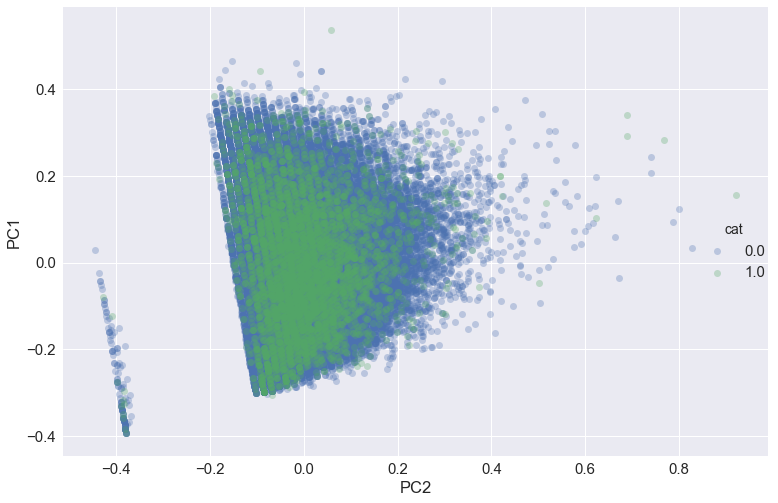

In [23]:
ax = sns.lmplot(data = xPcaDataframe, x='PC2', y='PC1', hue='cat', size=10, aspect=20, fit_reg=False,
               scatter_kws={'alpha': 0.3})
fig = plt.gcf()
fig.set_size_inches(10, 7)

### Converting data for XGBoost

In [19]:

#dataPredict = dataPredict.drop(['SeriousDlqin2yrs'],axis=1)

featNames = ['RevolvingUtilizationOfUnsecuredLines', 'age',
 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
xgtrain = xgb.DMatrix(train_data.values, label=train_target, feature_names=featNames )
xgtest = xgb.DMatrix(test_data.values, label=test_target, feature_names=featNames)
#xgpredict = xgb.DMatrix(dataPredict, label=None, feature_names=featNames)

In [20]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1,
    'eta':0.4
}
params['eval_metric'] = ['error', 'auc']

num_rounds = 30

watchlist  = [(xgtest,'test'), (xgtrain,'train')] # native interface only
bst = xgb.train(params, xgtrain, num_rounds, watchlist, early_stopping_rounds=5)
print("Best train score: {}".format(bst.best_score))
print("Best iteration: {}".format(bst.best_iteration))
print("Best number of trees limit: {}".format(bst.best_ntree_limit))

[0]	test-error:0.064089	test-auc:0.793462	train-error:0.06441	train-auc:0.81094
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 5 rounds.
[1]	test-error:0.063889	test-auc:0.819649	train-error:0.063495	train-auc:0.833003
[2]	test-error:0.063978	test-auc:0.826176	train-error:0.063314	train-auc:0.838074
[3]	test-error:0.063933	test-auc:0.829191	train-error:0.0632	train-auc:0.839551
[4]	test-error:0.0638	test-auc:0.83508	train-error:0.063324	train-auc:0.84552
[5]	test-error:0.063667	test-auc:0.839053	train-error:0.063124	train-auc:0.849088
[6]	test-error:0.063622	test-auc:0.841369	train-error:0.063095	train-auc:0.852376
[7]	test-error:0.063511	test-auc:0.841946	train-error:0.062943	train-auc:0.853048
[8]	test-error:0.063444	test-auc:0.844726	train-error:0.062933	train-auc:0.856525
[9]	test-error:0.063556	test-auc:0.847275	train-error:0.062771	train-auc:0.859647
[10]	test-error:0.063489	test-auc:0.850363	tra

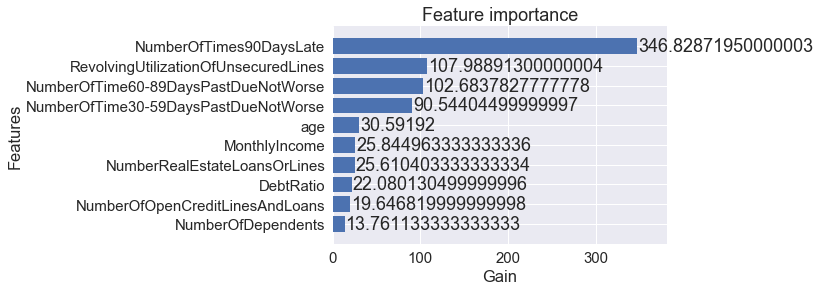

In [31]:
bst.save_model('gen_data/featMap.txt')
trees_dump = bst.get_dump(fmap='gen_data/featMap.txt', with_stats=False)
xgb.plot_importance(bst, importance_type='gain', xlabel='Gain', height=0.8)

In [14]:
seed = 10000
num_rounds = 10
params1 = {
    'objective':'binary:logistic',
    'max_depth':5,
    'silent':1,
    'eta':0.4
}
hist = xgb.cv(params1, xgtrain, num_rounds, nfold=10, metrics={'auc'}, seed=seed)
hist

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.842843,0.009127,0.845838,0.004082
1,0.850512,0.004883,0.852296,0.001248
2,0.851347,0.005122,0.854889,0.001451
3,0.852761,0.005764,0.856301,0.001038
4,0.853950,0.005784,0.858107,0.001264
5,0.855851,0.005907,0.860580,0.000959
6,0.857308,0.006151,0.862628,0.001172
7,0.858018,0.005690,0.864992,0.001359
8,0.860426,0.005661,0.868104,0.000806
9,0.861502,0.005403,0.869837,0.001005


In [16]:
y_test_preds = (bst.predict(xgb.DMatrix(test_data, feature_names=featNames)) > 0.5).astype('int')
pd.crosstab(
    pd.Series(test_target, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0.0,1.0,All
Actual,,,
0.0,12225,309,12534
1.0,882,20,902
All,13107,329,13436


In [17]:
print('Accuracy: {0:.2f}'.format(accuracy_score(test_target, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(test_target, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(test_target, y_test_preds)))

Accuracy: 0.94
Precision: 0.58
Recall: 0.20


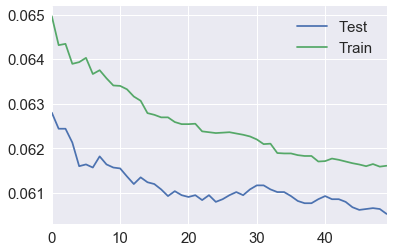

In [57]:
datatoplot = np.array([
[ 0.0628,  0.820171,  0.064962,  0.811279],
[ 0.06244,  0.831499,  0.064314,  0.822121],
[ 0.06244,  0.842962,  0.064343,  0.8339],
[ 0.06213,  0.84863,  0.063895,  0.840267],
[ 0.0616,  0.848985,  0.063933,  0.840893],
[ 0.06164,  0.850989,  0.064029,  0.842826],
[ 0.06157,  0.853625,  0.063667,  0.846211],
[ 0.06182,  0.856527,  0.063752,  0.850411],
[ 0.06164,  0.856983,  0.063571,  0.85089],
[ 0.06157,  0.860585,  0.06341,  0.853854],
[0.06155, 0.863456, 0.0634, 0.858028],
[0.06137, 0.864886, 0.063324, 0.860163],
[0.0612, 0.865086, 0.063162, 0.860529],
[0.06135, 0.865767, 0.063067, 0.861396],
[0.06124, 0.866628, 0.06279, 0.862434],
[0.0612, 0.866872, 0.062752, 0.863035],
[0.06108, 0.867655, 0.062695, 0.863599],
[0.06093, 0.867965, 0.062695, 0.864015],
[0.06104, 0.868453, 0.06259, 0.864879],
[0.06095, 0.86875, 0.062543, 0.865641],
[0.06091, 0.868882, 0.062543, 0.865895],
[0.06095, 0.869158, 0.062552, 0.866287],
[0.06084, 0.869297, 0.062381, 0.86641],
[0.06095, 0.869619, 0.062362, 0.866952],
[0.0608, 0.869718, 0.062343, 0.867084],
[0.06086, 0.869943, 0.062352, 0.867457],
[0.06095, 0.87003, 0.062362, 0.867867],
[0.06102, 0.870297, 0.062333, 0.868068],
[0.06095, 0.870054, 0.062305, 0.868399],
[0.06108, 0.870209, 0.062267, 0.868753],
[0.06117, 0.870153, 0.0622, 0.86896],
[0.06117, 0.870236, 0.062095, 0.869171],
[0.06108, 0.870249, 0.062105, 0.869241],
[0.06102, 0.870211, 0.061895, 0.869535],
[0.06102, 0.870233, 0.061886, 0.869665],
[0.06093, 0.870261, 0.061886, 0.869769],
[0.06082, 0.870443, 0.061848, 0.869947],
[0.06077, 0.870439, 0.061829, 0.870017],
[0.06077, 0.870505, 0.061829, 0.870133],
[0.06086, 0.870567, 0.061705, 0.870328],
[0.06093, 0.870464, 0.061714, 0.870646],
[0.06086, 0.870447, 0.061771, 0.870942],
[0.06086, 0.870512, 0.061743, 0.871178],
[0.0608, 0.870523, 0.061705, 0.871415],
[0.06068, 0.870626, 0.061667, 0.871659],
[0.06062, 0.870768, 0.061638, 0.871871],
[0.06064, 0.870871, 0.0616, 0.872258],
[0.06066, 0.870851, 0.061648, 0.872639],
[0.06064, 0.870894, 0.06159, 0.872875],
[0.06053, 0.870829, 0.06161, 0.873127]
]
)
df = pd.DataFrame(datatoplot[:,::2], columns=list(['Test','Train']))
df.plot()


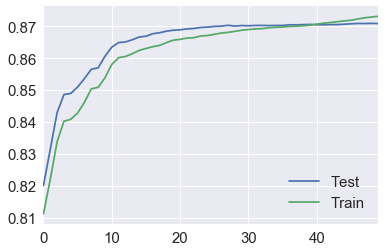

In [58]:
df = pd.DataFrame(datatoplot[:,1::2], columns=list(['Test','Train']))
df.plot()